In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Reading Data

The following cell reads the data and places it in a dictionary formatted to:
```
{
    sub_id: {
        run_id: {
            "eeg": [],
            "aux": [],
            "label": []
        }
    }
}
```

In [2]:
def bandpass_filter(data, lowcut=0.5, highcut=40, fs=250, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1) 

In [3]:
# data loading
eeg_dir = "data/misc/"
label_dir = "data/label/"

data = {}

# reading data
for sub_id in os.listdir(eeg_dir):
    data[sub_id] = {}

    dir_path = os.path.join(eeg_dir, sub_id) 
    for run_id in os.listdir(dir_path):

        # ignoring corrupt data
        if run_id == "run_34":
            continue

        if sub_id == "sub_1":
            if run_id in ["run_1", "run_3"]:
                continue

        if sub_id == "sub_3":
            if run_id in ["run_2", "run_5"]:
                continue


        # getting run number
        i = int(run_id.replace("run_", ""))

        # getting path for aux and eeg
        base_path = os.path.join(dir_path, run_id)
        eeg_path = os.path.join(base_path, f"eeg_run-{i}.npy")
        aux_path = os.path.join(base_path, f"aux_run-{i}.npy")

        # getting path for label
        base_path_label = os.path.join(label_dir, sub_id)
        base_path_label = os.path.join(base_path_label, run_id)

        
        label_path = os.path.join(base_path_label, "labels.npy")

        filtered_eeg = bandpass_filter(np.load(eeg_path))
        
        data[sub_id][run_id] = {
            "eeg": np.load(eeg_path),
            "filtered_eeg": filtered_eeg,
            "aux": np.load(aux_path),
            "label": np.load(label_path)
        }        

## Data Visualization

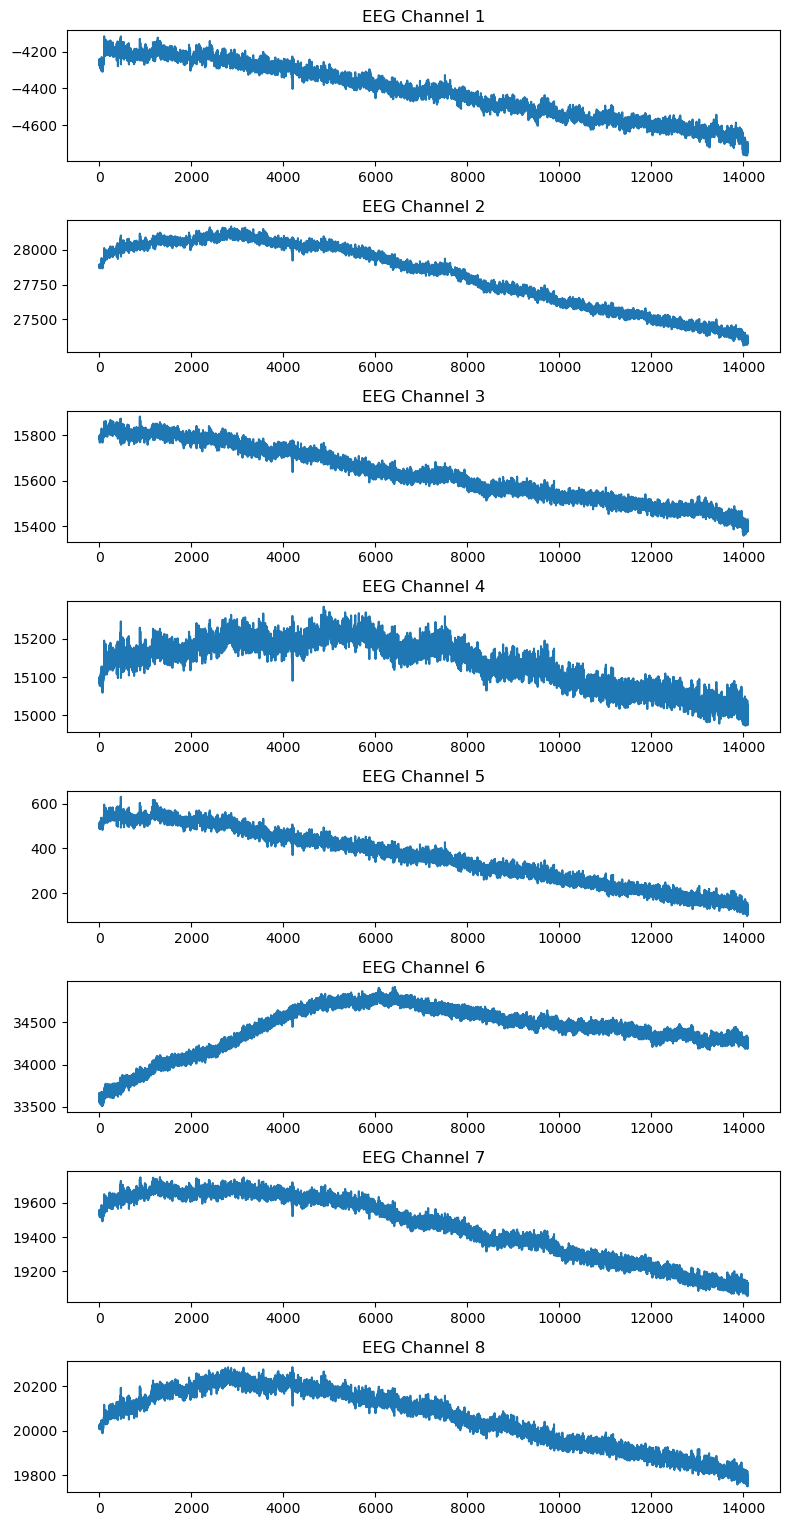

In [4]:
sub_id = "sub_1"
run_id = "run_2"
ignore = 100

eeg_data = data[sub_id][run_id]["eeg"]

# Create subplots
fig, axes = plt.subplots(8, 1, figsize=(8, 16))

for i, ax in enumerate(axes):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

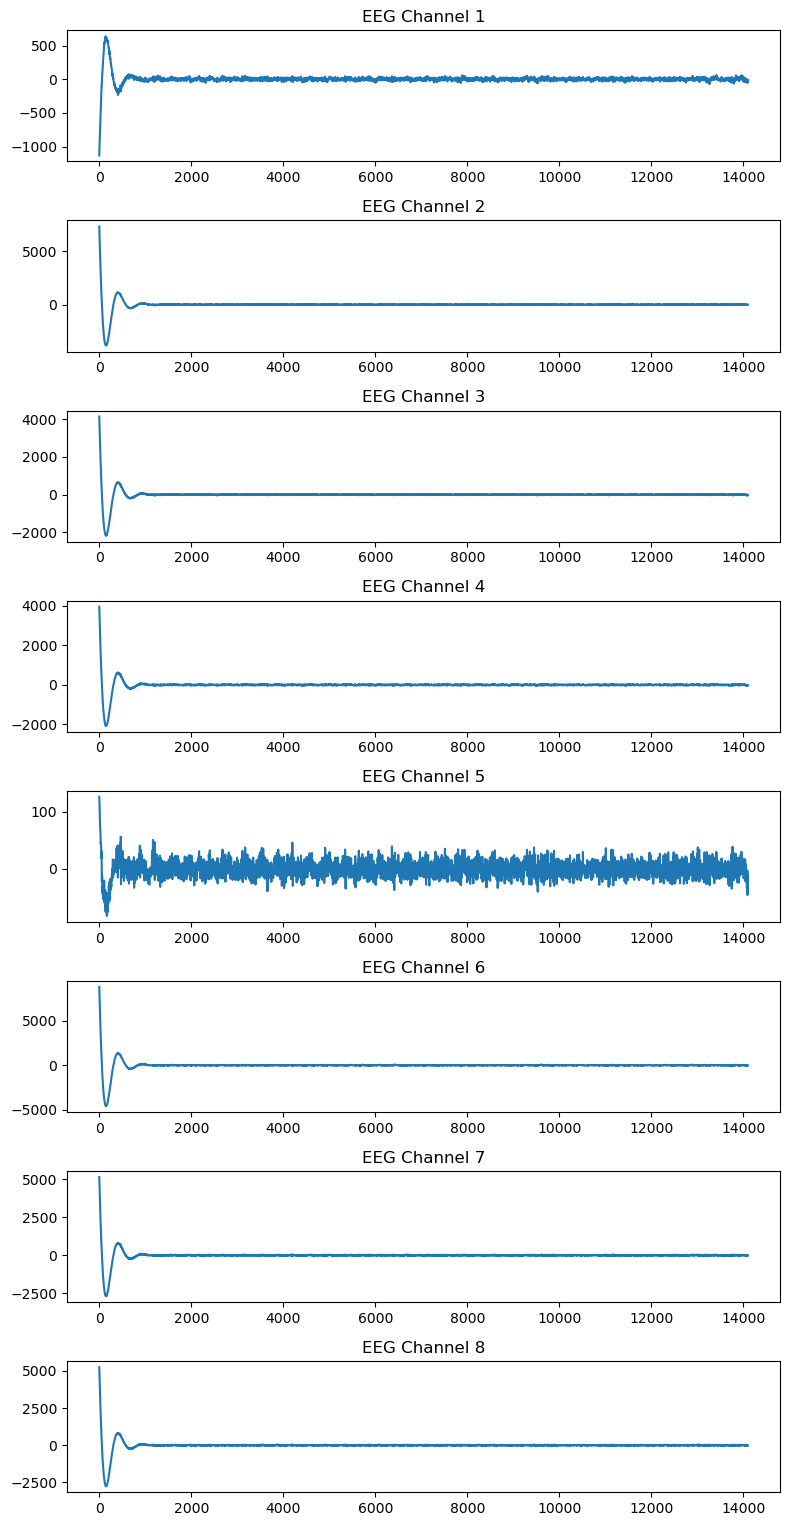

In [5]:
eeg_data = data[sub_id][run_id]["filtered_eeg"]

# Create subplots
fig, axes = plt.subplots(8, 1, figsize=(8, 16))

for i, ax in enumerate(axes):
    ax.plot(np.arange(len(eeg_data[i][ignore:])), eeg_data[i][ignore:])
    ax.set_title(f"EEG Channel {i+1}")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

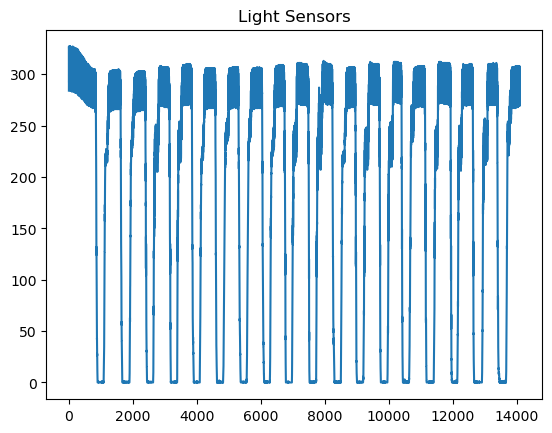

In [6]:
ignore = 100

aux_data = data[sub_id][run_id]["aux"][1]

plt.plot(np.arange(len(aux_data[ignore:])), aux_data[ignore:])
plt.title(f"Light Sensors")
plt.show()

## Cleaning the data

In [7]:
ignore = 100
pre_onset_window = 200
sample_window = 200 + pre_onset_window
cleaned_data = {}

for sub_id in list(data.keys()):
    eeg_window = []
    labels = []
    
    for run_id in list(data[sub_id].keys()):
        aux_data = data[sub_id][run_id]["aux"][1][ignore:]
        eeg_data = data[sub_id][run_id]["filtered_eeg"][:, ignore:]
        label_data = data[sub_id][run_id]["label"]
    
        labels.append(label_data)
    
        window_mask = aux_data > 10
        prev = False
        window = []
        for i, mask in enumerate(window_mask):
            if mask:
                if len(window) == 0:
                    for j in range(i-pre_onset_window, i):
                        window.append(eeg_data[:, j])
                
                window.append(eeg_data[:, i])
        
            if prev and not mask and len(window) > (100 + pre_onset_window):
                eeg_window.append(np.asarray(window))
                window = []
                
            prev = mask

    labels = np.asarray(labels).flatten()

    # asserting if data is valid
    print(len(eeg_window), len(labels))
    assert len(eeg_window) == len(labels)

    # First, split into train (70%) and temp (30%)
    eeg_train, eeg_temp, label_train, label_temp = train_test_split(
        eeg_window, labels, test_size=0.4, stratify=labels, random_state=3
    )
    
    # Split temp into validation (50%) and test (50%) ensuring stratification
    eeg_val, eeg_test, label_val, label_test = train_test_split(
        eeg_temp, label_temp, test_size=0.5, stratify=label_temp, random_state=3
    )
    
    # Store in dictionary
    cleaned_data[sub_id] = {
        "train": {"eeg": eeg_train, "label": label_train},
        "val": {"eeg": eeg_val, "label": label_val},
        "test": {"eeg": eeg_test, "label": label_test}
    }

54 54
90 90
54 54
90 90


## Dataloader

In [8]:
class Dataset(Dataset):
    def __init__(self, data: dict, mode: str, sample_window=150):
        """
        Args:
            data: (dict) cleaned data with {eeg: [c, t], label: [t]} where
                        c is channels, and t is time
            mode: (str) one of ["hand", "rps", "both"]
        """
        if mode not in ["hand", "rps", "both"]:
            raise Exception("Not a valid mode, choose one of ['hand', 'rps', 'both']")

        self.mode = mode
        self.eeg_data = data["eeg"]
        self.sample_window = sample_window
        
        if self.mode == "hand":
            self.num_classes = 2
            self.labels = []

            for l in data["label"]:
                if "right" in l:
                    self.labels.append(0)

                elif "left" in l:
                    self.labels.append(1)

                else:
                    raise Exception("incorrect label")

        elif self.mode == "rps":
            self.num_classes = 3
            self.labels = []

            for l in data["label"]:
                if "rock" in l:
                    self.labels.append(0)

                elif "paper" in l:
                    self.labels.append(1)

                elif "scissor" in l:
                    self.labels.append(2)

                else:
                    raise Exception("incorrect label")

        else:
            self.num_classes = 6
            self.labels = []
            
            mapping = {
                "left_rock": 0, 
                "left_paper": 1, 
                "left_scissors": 2, 
                "right_rock": 3, 
                "right_paper": 4, 
                "right_scissors": 5
            }
            
            for l in data["label"]:
                if l not in list(mapping.keys()):
                    raise Exception("incorrect label")

                self.labels.append(mapping[l])


    def __len__(self):
        return len(eeg_data)

    def __getitem__(self, idx):
        eeg = self.eeg_data[idx].transpose()[:, :self.sample_window]
        label = self.labels[idx]

        
        target = np.zeros([self.num_classes])
        target[label] = 1
        return torch.tensor(eeg).to(torch.float32), torch.tensor(target).to(torch.float32)

## Modelling Task 1: Left vs Right

In [9]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=2, channels=8):
        super(EEGNet, self).__init__()
        # Depthwise Convolution
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding=(0, 32))
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (channels, 1), groups=16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(0.25)

        # Separable Convolution
        self.conv3 = nn.Conv2d(32, 32, (1, 16), padding=(0, 8))
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.pool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(0.25)


        # Fully Connected Layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension [B, 1, C, T]
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.elu(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pool1(x)
        x = self.dropout1(x)


        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pool2(x)
        x = self.dropout2(x)


        x = self.flatten(x)
        x = self.fc1(x)

        # return F.log_softmax(x, dim=1)
        return x

def plot_cm(cm, sub_id):
     # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {sub_id}")
    plt.show()
    

In [10]:
batch_size = 4
epochs = 1000
num_classes = 2

mode = "hand"
results = {}

for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_classes=num_classes)
    # model = EEGClassifier(num_classes=num_classes, seq_length=sample_window)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='binary')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0196, Val Loss: 1.0397
Epoch 200/1000, Loss: 0.0253, Val Loss: 1.2190
Epoch 300/1000, Loss: 0.0226, Val Loss: 1.0673
Epoch 400/1000, Loss: 0.0211, Val Loss: 1.0692
Epoch 500/1000, Loss: 0.0244, Val Loss: 1.0604
Epoch 600/1000, Loss: 0.0283, Val Loss: 1.0243
Epoch 700/1000, Loss: 0.0296, Val Loss: 1.0488
Epoch 800/1000, Loss: 0.0166, Val Loss: 1.0598
Epoch 900/1000, Loss: 0.0275, Val Loss: 1.2172
Epoch 1000/1000, Loss: 0.0291, Val Loss: 1.1696
============== sub_2 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0938, Val Loss: 0.9629
Epoch 200/1000, Loss: 0.1148, Val Loss: 0.9577
Epoch 300/1000, Loss: 0.1216, Val Loss: 0.9906
Epoch 400/1000, Loss: 0.0956, Val Loss: 1.0654
Epoch 500/1000, Loss: 0.1393, Val Loss: 0.9866
Epoch 600/1000, Loss: 0.1211, Val Loss: 1.0965
Epoch 700/1000, Loss: 0.1205, Val Loss: 1.0365
Epoch 800/1000, Loss: 0.0946, Val Loss: 1.0884
Epoch 900/1000, Loss: 0.1035, Val Loss: 1.0922
Epoch 1000/1000, Loss: 0.0924, Val Loss: 1.0282
============== sub_3 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0102, Val Loss: 2.3555
Epoch 200/1000, Loss: 0.0086, Val Loss: 2.0999
Epoch 300/1000, Loss: 0.0164, Val Loss: 2.2736
Epoch 400/1000, Loss: 0.0110, Val Loss: 2.3048
Epoch 500/1000, Loss: 0.0118, Val Loss: 2.1330
Epoch 600/1000, Loss: 0.0084, Val Loss: 2.1706
Epoch 700/1000, Loss: 0.0130, Val Loss: 2.0994
Epoch 800/1000, Loss: 0.0095, Val Loss: 2.0953
Epoch 900/1000, Loss: 0.0067, Val Loss: 2.2709
Epoch 1000/1000, Loss: 0.0062, Val Loss: 2.1034
============== sub_4 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0085, Val Loss: 0.8818
Epoch 200/1000, Loss: 0.0092, Val Loss: 0.9107
Epoch 300/1000, Loss: 0.0113, Val Loss: 1.0843
Epoch 400/1000, Loss: 0.0132, Val Loss: 1.0270
Epoch 500/1000, Loss: 0.0116, Val Loss: 1.0609
Epoch 600/1000, Loss: 0.0076, Val Loss: 1.0278
Epoch 700/1000, Loss: 0.0140, Val Loss: 0.8472
Epoch 800/1000, Loss: 0.0100, Val Loss: 0.8530
Epoch 900/1000, Loss: 0.0118, Val Loss: 0.7819
Epoch 1000/1000, Loss: 0.0086, Val Loss: 0.9999


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Baseline (Random guess): 0.5
sub_1 ==> Precision: 0.6666666666666666, Recall: 0.5, F1-score: 0.5714285714285714


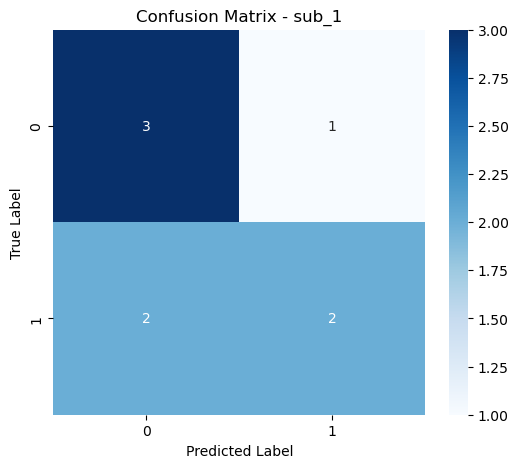

sub_2 ==> Precision: 0.25, Recall: 0.5, F1-score: 0.3333333333333333


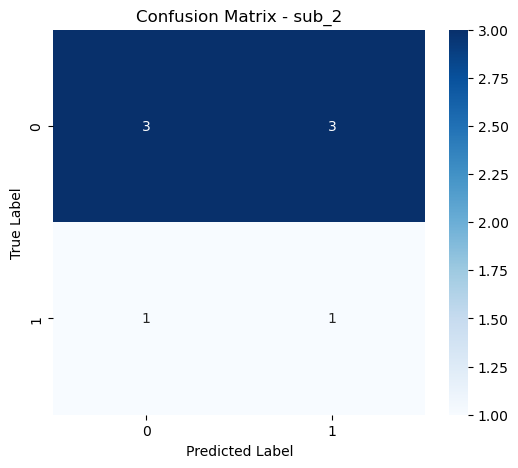

sub_3 ==> Precision: 0.6, Recall: 0.75, F1-score: 0.6666666666666666


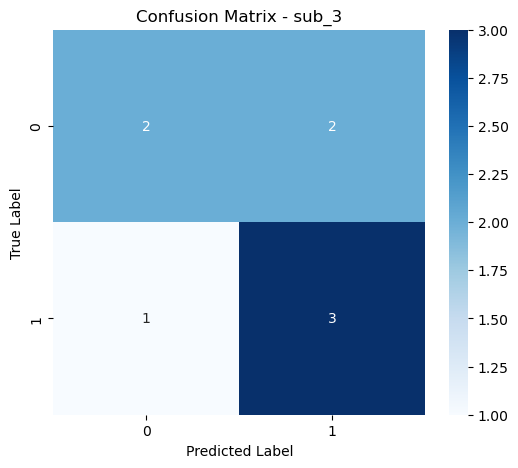

sub_4 ==> Precision: 0.0, Recall: 0.0, F1-score: 0.0


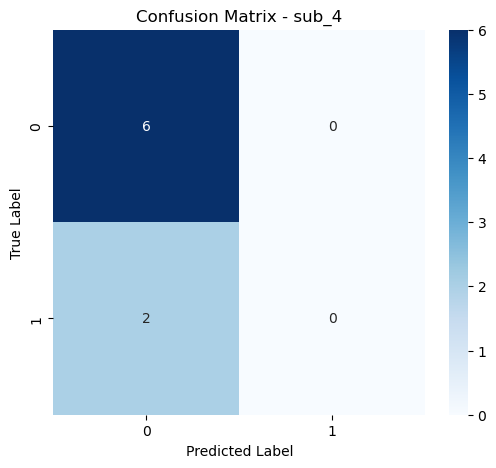

In [11]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)

## Modelling Task 2: Rock vs Paper vs Scisors

In [12]:
batch_size = 1
num_classes = 3

mode = "rps"
results = {}

for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_classes=num_classes)
    # model = EEGClassifier(num_classes=num_classes, seq_length=sample_window)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multi-class
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0221, Val Loss: 1.4023
Epoch 200/1000, Loss: 0.0159, Val Loss: 1.3782
Epoch 300/1000, Loss: 0.0181, Val Loss: 1.2055
Epoch 400/1000, Loss: 0.0231, Val Loss: 1.4379
Epoch 500/1000, Loss: 0.0171, Val Loss: 1.3831
Epoch 600/1000, Loss: 0.0242, Val Loss: 1.5029
Epoch 700/1000, Loss: 0.0211, Val Loss: 1.4167
Epoch 800/1000, Loss: 0.0188, Val Loss: 1.5125
Epoch 900/1000, Loss: 0.0181, Val Loss: 1.5620
Epoch 1000/1000, Loss: 0.0225, Val Loss: 1.4182
============== sub_2 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0535, Val Loss: 2.7459
Epoch 200/1000, Loss: 0.0386, Val Loss: 3.0502
Epoch 300/1000, Loss: 0.0373, Val Loss: 3.1008
Epoch 400/1000, Loss: 0.0353, Val Loss: 2.7632
Epoch 500/1000, Loss: 0.0404, Val Loss: 2.7674
Epoch 600/1000, Loss: 0.0427, Val Loss: 3.2548
Epoch 700/1000, Loss: 0.0348, Val Loss: 2.7156
Epoch 800/1000, Loss: 0.0339, Val Loss: 3.1026
Epoch 900/1000, Loss: 0.0277, Val Loss: 3.0338
Epoch 1000/1000, Loss: 0.0384, Val Loss: 2.7969
============== sub_3 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0992, Val Loss: 2.1121
Epoch 200/1000, Loss: 0.1065, Val Loss: 1.8134
Epoch 300/1000, Loss: 0.0894, Val Loss: 1.8603
Epoch 400/1000, Loss: 0.0705, Val Loss: 1.7801
Epoch 500/1000, Loss: 0.0810, Val Loss: 1.9088
Epoch 600/1000, Loss: 0.0955, Val Loss: 1.7821
Epoch 700/1000, Loss: 0.1183, Val Loss: 2.0373
Epoch 800/1000, Loss: 0.1134, Val Loss: 1.9985
Epoch 900/1000, Loss: 0.0988, Val Loss: 1.8636
Epoch 1000/1000, Loss: 0.1037, Val Loss: 1.9190
============== sub_4 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0104, Val Loss: 1.6808
Epoch 200/1000, Loss: 0.0134, Val Loss: 1.5343
Epoch 300/1000, Loss: 0.0116, Val Loss: 1.5704
Epoch 400/1000, Loss: 0.0112, Val Loss: 1.7456
Epoch 500/1000, Loss: 0.0156, Val Loss: 1.6277
Epoch 600/1000, Loss: 0.0070, Val Loss: 1.6476
Epoch 700/1000, Loss: 0.0095, Val Loss: 1.5849
Epoch 800/1000, Loss: 0.0097, Val Loss: 1.7336
Epoch 900/1000, Loss: 0.0098, Val Loss: 1.6474
Epoch 1000/1000, Loss: 0.0132, Val Loss: 1.7641


Baseline (Random guess): 0.3333333333333333
sub_1 ==> Precision: 0.7000000000000001, Recall: 0.611111111111111, F1-score: 0.59375


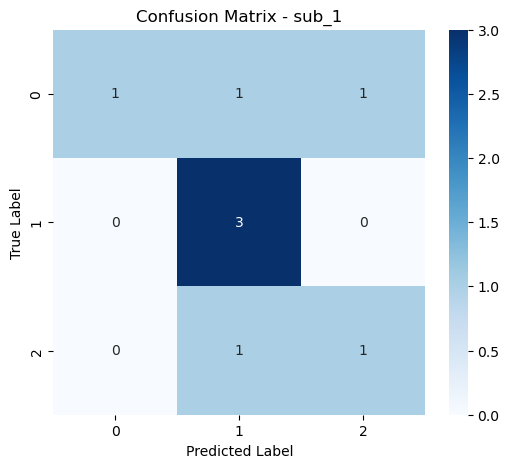

sub_2 ==> Precision: 0.08333333333333333, Recall: 0.3333333333333333, F1-score: 0.1


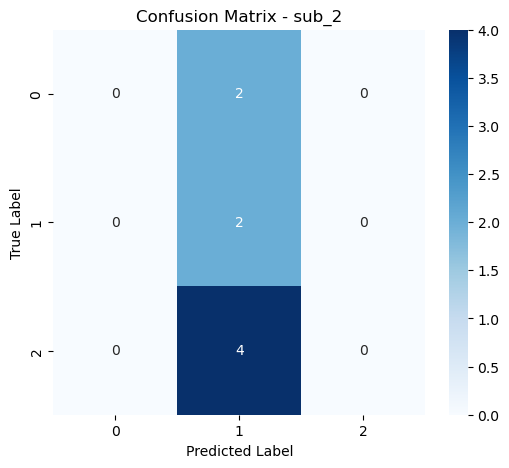

sub_3 ==> Precision: 0.3333333333333333, Recall: 0.4444444444444444, F1-score: 0.4


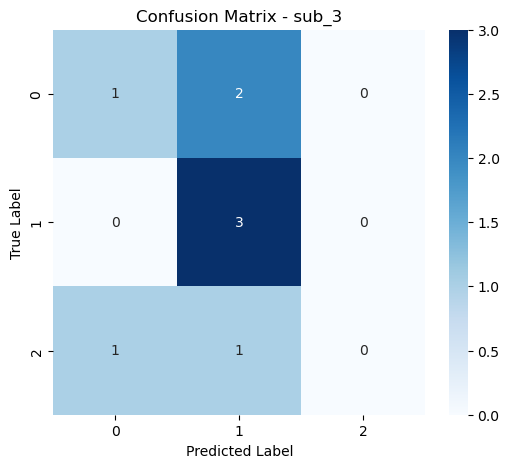

sub_4 ==> Precision: 0.38888888888888884, Recall: 0.4166666666666667, F1-score: 0.3666666666666667


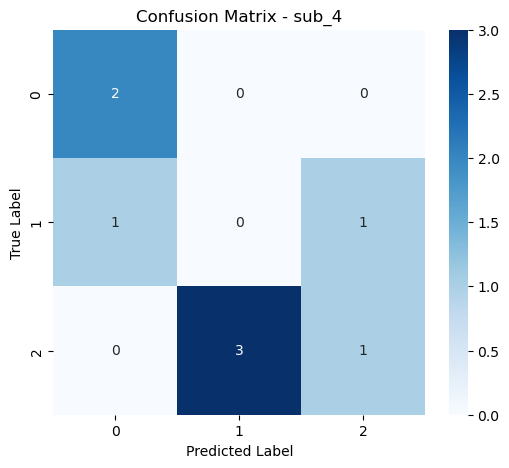

In [13]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)

## Modelling Task 3: Rock vs Paper vs Scisors

In [14]:
batch_size = 1
num_classes = 6

mode = "both"
results = {}

for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    print(f"============== {sub_id} ==============\n")
    # sample_window = min(min([val.shape[0] for val in cleaned_data[sub_id]["train"]["eeg"]]), min([val.shape[0] for val in cleaned_data[sub_id]["test"]["eeg"]]))
    
    print(f"sample_window = {sample_window}")
    train_set = Dataset(cleaned_data[sub_id]["train"], mode=mode, sample_window=sample_window)
    val_set = Dataset(cleaned_data[sub_id]["val"], mode=mode, sample_window=sample_window)
    test_set = Dataset(cleaned_data[sub_id]["test"], mode=mode, sample_window=sample_window)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = EEGNet(num_classes=num_classes)
    # model = EEGClassifier(num_classes=num_classes, seq_length=sample_window)
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0
        correct = 0
        for steps, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
    
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        for steps, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = criterion(output, target)
     
            val_loss += loss.item()

        scheduler.step(val_loss/len(val_loader))

        if (epoch+1) % 100 == 0: 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    # evaluating
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            gt = target.argmax(dim=1, keepdim=True)
            y_pred.append(pred.squeeze().cpu().detach().numpy())
            y_true.append(gt.squeeze().cpu().detach().numpy())
    
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results[sub_id] = {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "conf_mat": confusion_matrix(y_true, y_pred),
    }

============== sub_1 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0217, Val Loss: 2.1206
Epoch 200/1000, Loss: 0.0204, Val Loss: 2.1781
Epoch 300/1000, Loss: 0.0313, Val Loss: 2.3868
Epoch 400/1000, Loss: 0.0242, Val Loss: 2.3422
Epoch 500/1000, Loss: 0.0269, Val Loss: 2.2975
Epoch 600/1000, Loss: 0.0258, Val Loss: 2.2465
Epoch 700/1000, Loss: 0.0248, Val Loss: 2.2364
Epoch 800/1000, Loss: 0.0274, Val Loss: 2.3493
Epoch 900/1000, Loss: 0.0222, Val Loss: 2.2617
Epoch 1000/1000, Loss: 0.0233, Val Loss: 2.2036
============== sub_2 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0885, Val Loss: 2.7968
Epoch 200/1000, Loss: 0.0941, Val Loss: 3.0627
Epoch 300/1000, Loss: 0.0604, Val Loss: 2.7079
Epoch 400/1000, Loss: 0.0651, Val Loss: 2.8032
Epoch 500/1000, Loss: 0.0840, Val Loss: 2.9170
Epoch 600/1000, Loss: 0.0630, Val Loss: 2.8729
Epoch 700/1000, Loss: 0.0809, Val Loss: 2.8715
Epoch 800/1000, Loss: 0.0915, Val Loss: 2.8512
Epoch 900/1000, Loss: 0.0947, Val Loss: 2.6254
Epoch 1000/1000, Loss: 0.0764, Val Loss: 2.8621
============== sub_3 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.2194, Val Loss: 3.3242
Epoch 200/1000, Loss: 0.2738, Val Loss: 3.1171
Epoch 300/1000, Loss: 0.2222, Val Loss: 3.3362
Epoch 400/1000, Loss: 0.2178, Val Loss: 3.1383
Epoch 500/1000, Loss: 0.2255, Val Loss: 3.1663
Epoch 600/1000, Loss: 0.2521, Val Loss: 3.0471
Epoch 700/1000, Loss: 0.1802, Val Loss: 3.3357
Epoch 800/1000, Loss: 0.1915, Val Loss: 3.3491
Epoch 900/1000, Loss: 0.2104, Val Loss: 3.4504
Epoch 1000/1000, Loss: 0.1731, Val Loss: 3.0791
============== sub_4 ==============

sample_window = 400


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 100/1000, Loss: 0.0241, Val Loss: 2.7443
Epoch 200/1000, Loss: 0.0201, Val Loss: 2.3724
Epoch 300/1000, Loss: 0.0175, Val Loss: 2.6425
Epoch 400/1000, Loss: 0.0177, Val Loss: 2.5830
Epoch 500/1000, Loss: 0.0248, Val Loss: 2.6657
Epoch 600/1000, Loss: 0.0201, Val Loss: 2.4287
Epoch 700/1000, Loss: 0.0242, Val Loss: 2.5945
Epoch 800/1000, Loss: 0.0201, Val Loss: 2.7517
Epoch 900/1000, Loss: 0.0223, Val Loss: 2.5696
Epoch 1000/1000, Loss: 0.0194, Val Loss: 2.4728


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Baseline (Random guess): 0.16666666666666666
sub_1 ==> Precision: 0.02857142857142857, Recall: 0.2, F1-score: 0.03125


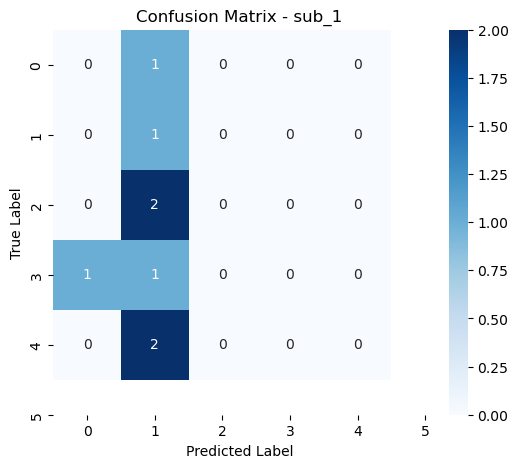

sub_2 ==> Precision: 0.041666666666666664, Recall: 0.08333333333333333, F1-score: 0.08333333333333333


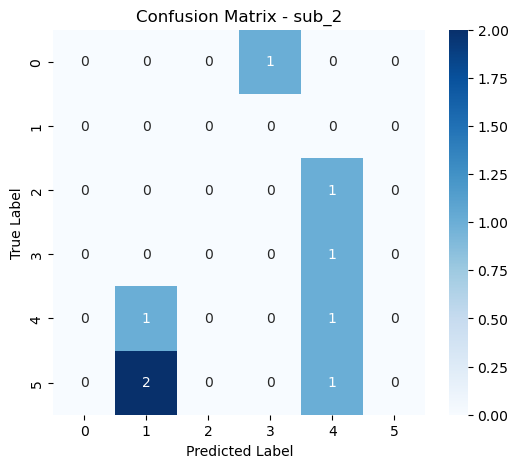

sub_3 ==> Precision: 0.06666666666666667, Recall: 0.2, F1-score: 0.125


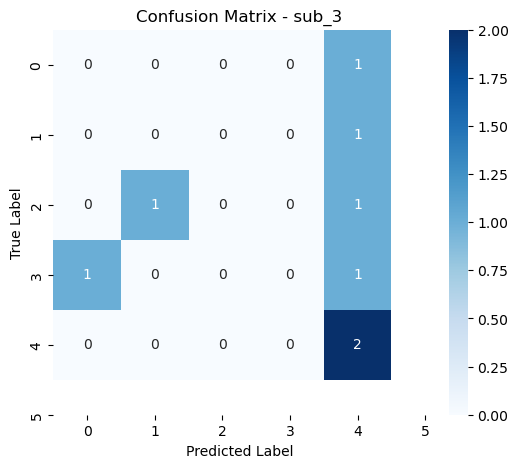

sub_4 ==> Precision: 0.05555555555555555, Recall: 0.16666666666666666, F1-score: 0.0625


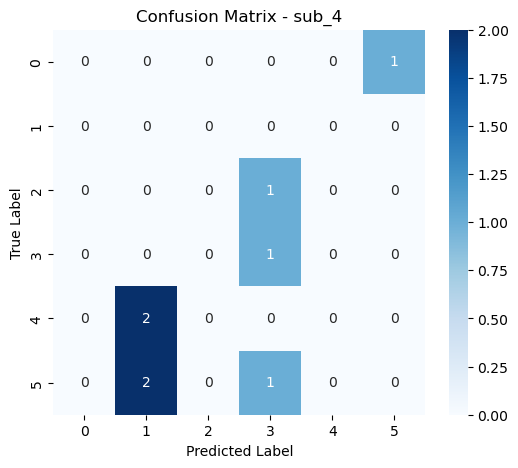

In [15]:
print(f"Baseline (Random guess): {1/num_classes}")
for sub_id in ["sub_1", "sub_2", "sub_3", "sub_4"]:
    f1 = results[sub_id]["f1"]
    precision = results[sub_id]["precision"]
    recall = results[sub_id]["recall"]
    print(f"{sub_id} ==> Precision: {precision}, Recall: {recall}, F1-score: {f1}")
    plot_cm(results[sub_id]["conf_mat"], sub_id)